In [1]:
import numpy as np
import tensorflow as tf

## Anchor Generation Layer

In [2]:
def _extract_cor(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    # anchor is 1X4
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5*(w-1)
    return w,h,x_ctr,y_ctr

In [3]:
def _make_anchors(ws,hs,x_ctr,y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center (x_ctr,y_ctr),
    Return a set of anchor boxes in (w, h, x_ctr, y_ctr) format.
    """
    # ws,hs,x_ctr,y_ctr are numpy arrays
    w = ws[:,np.newaxis] # [1,4] -> [4,1] i.e it generate array of one more dimension
    # print('w in mkanchors: ',w)
    h = hs[:,np.newaxis] # [1,4] -> [4,1]
    # print('h in mkanchors: ',h)
    anchors = np.hstack((x_ctr - 0.5*(w-1),
                                            y_ctr - 0.5*(h-1),
                                            x_ctr + 0.5*(w-1),
                                            y_ctr + 0.5*(h-1))) # horizontal stack
    # print('anchors in mkanchors: ',anchors)
    return anchors

In [4]:
def _ratio_enum(anchor,ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    
    w,h,x_ctr,y_ctr = _extract_cor(anchor)
    # print(w,h,x_ctr,y_ctr)
    size = w*h
    # print('size='+str(size))
    size_ratios = size/ratios
    # print('size_ratios='+str(size_ratios))
    ws = np.round(np.sqrt(size_ratios))
    # print('ws='+str(ws))
    hs = np.round(ws*ratios)
    # print('hs='+str(hs))
    anchors = _make_anchors(ws,hs,x_ctr,y_ctr)
    # print('anchors in ratio_enu='+str(anchors))
    return anchors

In [5]:
def _scale_enum(anchor,scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _extract_cor(anchor)
    # print("anchor in scle_enum="+str(anchor))
    ws = w*scales
    hs = h*scales
    anchors = _make_anchors(ws,hs,x_ctr,y_ctr)
    # print("Final anchors in scale_enum="+str(anchors))
    return anchors

In [6]:
#  It generates 9 anchor boxes from a base anchor box

def generate_anchors(base_size=16,ratios=[0.5,1,2],scales=np.array([8,16,32])):
    base_anchor = np.array([1,1,base_size,base_size]) - 1
    # print(base_anchor)
    ratio_anchors = _ratio_enum(base_anchor,ratios)
    # print(ratio_anchors.shape)
    anchors_list=[]
    for i in range(ratio_anchors.shape[0]):
        anc = _scale_enum(ratio_anchors[i,:],scales)
        anchors_list.append(anc)
    anchors = np.vstack(anchors_list)
    return anchors

In [7]:
generate_anchors()

array([[ -84. ,  -34.5,   99. ,   60.5],
       [-176. ,  -82.5,  191. ,  108.5],
       [-360. , -178.5,  375. ,  204.5],
       [ -56. ,  -56. ,   71. ,   71. ],
       [-120. , -120. ,  135. ,  135. ],
       [-248. , -248. ,  263. ,  263. ],
       [ -36. ,  -85.5,   51. ,   89.5],
       [ -80. , -173.5,   95. ,  177.5],
       [-168. , -349.5,  183. ,  353.5]])

In [8]:
# create uniformly spaced grid with spacing equal to stride

def generate_anchors_pre_tf(height, width, feat_stride=16, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
    """
    A wrapper function to generate anchors given different scales and
    ratios.
    """

    shift_x = tf.range(width) * feat_stride # [0,16,32,48] width
    shift_y = tf.range(height) * feat_stride # [0,16,32,48] height
    shift_x, shift_y = tf.meshgrid(shift_x, shift_y) # meshgrid cols, rows , meshgrid generates a grid of points in ND space
    # meshgrid enumerate shift_x row wise and shift_y col wise
    shift_x = tf.reshape(shift_x, shape=(-1,)) # reshape to 1D
    shift_y = tf.reshape(shift_y, shape=(-1,))
    shifts = tf.stack((shift_x, shift_y, shift_x, shift_y), axis=1) # vertical stack by row
    K = tf.multiply(width, height)
    shifts = tf.transpose(tf.reshape(shifts,shape=[1,K,4]),perm=[1,0,2]) # reshaping into Kx1x4

    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales)) # basic 9 anchor boxes of shape (9,4)
    A = anchors.shape[0] # 9
    anchor_constants = tf.constant(anchors.reshape((1, A, 4)), dtype=tf.int32) # reshape to 1x9x4
    
    length = K*A
    anchors_tf = tf.reshape(tf.add(anchor_constants,shifts),shape=[length,4]) # add shift to anchors element wise
    return tf.cast(anchors_tf,tf.float32),length

In [9]:
tensor_anchors, length = generate_anchors_pre_tf(height=600//16,width=800//16)
print("type of tensor_anchors: ",type(tensor_anchors))
print("tensor_anchors shape",tensor_anchors.shape)
print("length="+str(length))

type of tensor_anchors:  <class 'tensorflow.python.framework.ops.EagerTensor'>
tensor_anchors shape (16650, 4)
length=tf.Tensor(16650, shape=(), dtype=int32)


## For Bounding box regression coefficients

In [10]:
import numpy as np
import tensorflow as tf

In [11]:
# calculating bounding box regression coefficients
def bbox_transform(original_rois,gt_rois):
    original_widths = original_rois[:,2] - original_rois[:,0] + 1.0
    original_heights = original_rois[:,3] - original_rois[:,1] + 1.0
    original_ctr_x = original_rois[:,0] + 0.5 * original_widths
    original_ctr_y = original_rois[:,1] + 0.5 * original_heights

    gt_widths = gt_rois[:,2] - gt_rois[:,0] + 1.0
    gt_heights = gt_rois[:,3] - gt_rois[:,1] + 1.0
    gt_ctr_x = gt_rois[:,0] + 0.5 * gt_widths
    gt_ctr_y = gt_rois[:,1] + 0.5 * gt_heights

    targets_dx = (gt_ctr_x - original_ctr_x) / original_widths
    targets_dy = (gt_ctr_y - original_ctr_y) / original_heights
    targets_dw = np.log(gt_widths / original_widths)
    targets_dh = np.log(gt_heights / original_heights)

    targets = np.vstack((targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets

In [12]:
bbox_transform(np.array([[-1,-1,15,15],[-1,-1,31,31]]),np.array([[0,0,16,16],[0,0,32,32]]))

array([[0.05882353, 0.05882353, 0.        , 0.        ],
       [0.03030303, 0.03030303, 0.        , 0.        ]])

In [13]:
def bbox_transform_inv_tf(boxes, deltas):
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)
    
    boxes = tf.cast(boxes, deltas.dtype)
    Original_widths = boxes[:, 2] - boxes[:, 0] + 1.0
    Original_heights = boxes[:, 3] - boxes[:, 1] + 1.0
    Original_ctr_x = boxes[:, 0] + 0.5 * Original_widths
    Original_ctr_y = boxes[:, 1] + 0.5 * Original_heights

    targets_dx = deltas[:, 0::4]
    targets_dy = deltas[:, 1::4]
    targets_dw = deltas[:, 2::4]
    targets_dh = deltas[:, 3::4]

    pred_ctr_x = tf.add(tf.multiply(targets_dx, Original_widths), Original_ctr_x)
    pred_ctr_y = tf.add(tf.multiply(targets_dy, Original_heights), Original_ctr_y)
    pred_w = tf.multiply(tf.exp(targets_dw), Original_widths)
    pred_h = tf.multiply(tf.exp(targets_dh), Original_heights)

    pred_boxes0 = tf.subtract(pred_ctr_x,pred_w*0.5)
    pred_boxes1 = tf.subtract(pred_ctr_y,pred_h*0.5)
    pred_boxes2 = tf.add(pred_ctr_x,pred_w*0.5)
    pred_boxes3 = tf.add(pred_ctr_y,pred_h*0.5)

    predicted_boxes = tf.stack([pred_boxes0,pred_boxes1,pred_boxes2,pred_boxes3],axis=1)
    return predicted_boxes

In [14]:
def clip_boxes_tf(boxes, im_info):
    """
    Clip boxes to image boundaries.
    boxes: [N, 4* num_classes]
    im_info: [image_height, image_width, scale_ratios]
    """
    # x1 >= 0
    boxes[:, 0::4] = tf.maximum(tf.minimum(boxes[:, 0::4], im_info[1] - 1), 0)
    # y1 >= 0
    boxes[:, 1::4] = tf.maximum(tf.minimum(boxes[:, 1::4], im_info[0] - 1), 0)
    # x2 < im_info[1]
    boxes[:, 2::4] = tf.maximum(tf.minimum(boxes[:, 2::4], im_info[1] - 1), 0)
    # y2 < im_info[0]
    boxes[:, 3::4] = tf.maximum(tf.minimum(boxes[:, 3::4], im_info[0] - 1), 0)
    return boxes

## NMS - Non-Maximum Suppression

In [ ]:
import tensorflow as tf
nms = tf.image.non_max_suppression()

## Head Network

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [16]:
head_network = VGG16(weights='imagenet', include_top=False, input_shape=(600,800,3))

In [17]:
# top 18 layers of vgg16 for head network
head_network = Model(inputs=head_network.input, outputs=head_network.get_layer('block5_conv3').output)

In [18]:
head_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 800, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 600, 800, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 600, 800, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 300, 400, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 300, 400, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 300, 400, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 150, 200, 128)     0     

## Proposal Layer

In [19]:
import tensorflow as tf

In [20]:
def proposal_layer(rpn_cls_prob, rpn_bbox_pred, im_info, _feat_stride, anchors, num_anchors):
    pre_nms_topN = 12000
    post_nms_topN = 2000
    nms_thresh = 0.7

    scores = rpn_cls_prob[:, :, :, num_anchors:]
    scores = tf.reshape(scores, shape=(-1,))
    rpn_bbox_pred = tf.reshape(rpn_bbox_pred, shape=(-1, 4))

    proposals = bbox_transform_inv_tf(anchors, rpn_bbox_pred)
    proposals = clip_boxes_tf(proposals, im_info[:2])

    indices = tf.image.non_max_suppression(proposals, scores, max_output_size=post_nms_topN, iou_threshold=nms_thresh)
    boxes = tf.gather(proposals, indices)
    boxes = tf.to_float(boxes)
    scores = tf.gather(scores, indices)
    scores = tf.reshape(scores, shape=(-1, 1))

    batch_inds = tf.zeros((tf.shape(indices)[0],1), dtype=tf.float32)
    rois = tf.concat([batch_inds, boxes], axis=1)

    return rois, scores

### RPN network

In [21]:
import tf_slim as slim

initializer = tf.random_normal_initializer(mean=0.0, stddev=0.01)


In [22]:
def _region_proposal(net_conv,is_training,initializer):
    rpn = slim.conv2d(net_conv,512,[3,3],trainable=is_training,weights_initializer=initializer,scope='rpn_conv/3x3')
    rpn_cls_score = slim.conv2d(rpn,num_anchors*2,[1,1],trainable=is_training,weights_initializer=initializer,
                                padding='VALID',activation_fn=None,scope='rpn_cls_score')
    rpn_bbox_pred = slim.conv2d(rpn,*4,[1,1],trainable=is_training,weights_initializer=initializer,
                                padding='VALID',activation_fn=None,scope='rpn_bbox_pred')
    rpn_cls_prob = tf.nn.softmax(rpn_cls_score)
    rpn_cls_prob = tf.reshape(rpn_cls_prob,[-1,2])
    rpn_bbox_pred = tf.reshape(rpn_bbox_pred,[-1,4])
    return rpn_cls_prob,rpn_bbox_pred

### Anchor Target Layer

In [23]:
import numpy as np
import numpy.random as npr

In [24]:
def bbox_overlaps(boxes,query_boxes):
    """
    Parameters:
    ----------
    boxes: numpy array (N,4)
    query_boxes: numpy array (K,4)
    Returns:
    -------
    overlaps: numpy array (N,K)
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N,K),dtype=np.float)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0] + 1) *
            (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0]) + 1
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1]) + 1
                )
                if ih > 0:
                    ua = float((boxes[n, 2] - boxes[n, 0] + 1) *
                           (boxes[n, 3] - boxes[n, 1] + 1) + box_area - iw * ih)
                    overlaps[n, k] = iw * ih / ua
    return overlaps

In [25]:
## call bbox_overlaps
boxes = np.array([[0,0,1,1],[1,1,2,2],[3,3,4,4]])
query_boxes = np.array([[0,0,1,1],[1,1,2,2],[3,3,4,4],[0,0,1,1]])
overlaps = bbox_overlaps(boxes,query_boxes)
print(overlaps)
argmax_overlaps = overlaps.argmax(axis=0)
print(argmax_overlaps)

[[1.         0.14285714 0.         1.        ]
 [0.14285714 1.         0.         0.14285714]
 [0.         0.         1.         0.        ]]
[0 1 2 0]


In [26]:
RPN_NEGATIVE_OVERLAP = 0.3
RPN_POSITIVE_OVERLAP = 0.7
RPN_BATCHSIZE = 256
RPN_FG_FRACTION = 0.5
RPN_BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)

In [27]:
def anchor_target_layer(rpn_cls_score,gt_boxes,im_info,_feat_stride,all_anchors,num_anchors):
    A = num_anchors
    total_anchors = all_anchors.shape[0]
    K = total_anchors / num_anchors

    # allow boxes to sit over the edge by a small amount
    _allowed_border = 0

    # map of shape (..., H, W)
    height, width = rpn_cls_score.shape[1:3]

    # only keep anchors inside the image
    inds_inside = np.where(
        (all_anchors[:, 0] >= -_allowed_border) &
        (all_anchors[:, 1] >= -_allowed_border) &
        (all_anchors[:, 2] < im_info[1] + _allowed_border) &  # width
        (all_anchors[:, 3] < im_info[0] + _allowed_border)  # height
    )[0]

    # keep only inside anchors
    anchors = all_anchors[inds_inside, :]

    # label: 1 is positive, 0 is negative, -1 is dont care
    labels = np.empty((len(inds_inside),), dtype=np.float32)
    labels.fill(-1)

    # overlaps between the anchors and the gt boxes
    # overlaps (ex, gt)
    overlaps = bbox_overlaps(
        np.ascontiguousarray(anchors, dtype=np.float),
        np.ascontiguousarray(gt_boxes, dtype=np.float))
    argmax_overlaps = overlaps.argmax(axis=1)
    max_overlaps = overlaps[np.arange(len(inds_inside)), argmax_overlaps]
    gt_argmax_overlaps = overlaps.argmax(axis=0)
    gt_max_overlaps = overlaps[gt_argmax_overlaps,
                                 np.arange(overlaps.shape[1])]
    gt_argmax_overlaps = np.where(overlaps == gt_max_overlaps)[0]

    labels[max_overlaps < RPN_NEGATIVE_OVERLAP] = 0
    labels[gt_argmax_overlaps] = 1
    labels[max_overlaps >= RPN_POSITIVE_OVERLAP] = 1

    # subsample positive labels if we have too many
    num_fg = int(RPN_FG_FRACTION * RPN_BATCHSIZE)
    fg_inds = np.where(labels == 1)[0]
    if len(fg_inds) > num_fg:
        disable_inds = npr.choice(
            fg_inds, size=(len(fg_inds) - num_fg), replace=False)
        labels[disable_inds] = -1
    
    # subsample negative labels if we have too many
    num_bg = RPN_BATCHSIZE - np.sum(labels == 1)
    bg_inds = np.where(labels == 0)[0]
    if len(bg_inds) > num_bg:
        disable_inds = npr.choice(bg_inds, size=(len(bg_inds) - num_bg), replace=False)
        labels[disable_inds] = -1
    
    bbox_targets = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_targets = _compute_targets(anchors, gt_boxes[argmax_overlaps, :])

    bbox_inside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    bbox_inside_weights[labels == 1, :] = np.array(RPN_BBOX_INSIDE_WEIGHTS)

    bbox_outside_weights = np.zeros((len(inds_inside), 4), dtype=np.float32)
    
    bbox_outside_weights[labels == 1, :] = 1.0
    bbox_outside_weights[labels == 0, :] = 1.0

    # map up to original set of anchors
    labels = _unmap(labels, total_anchors, inds_inside, fill=-1)
    bbox_targets = _unmap(bbox_targets, total_anchors, inds_inside, fill=0)
    bbox_inside_weights = _unmap(bbox_inside_weights, total_anchors, inds_inside, fill=0)
    bbox_outside_weights = _unmap(bbox_outside_weights, total_anchors, inds_inside, fill=0)

    # labels
    labels = labels.reshape((1, height, width, A)).transpose(0, 3, 1, 2)
    labels = labels.reshape((1, 1, A * height, width))
    rpn_labels = labels

    # bbox_targets
    bbox_targets = bbox_targets.reshape((1, height, width, A * 4))
    
    rpn_bbox_targets = bbox_targets

    # bbox_inside_weights
    bbox_inside_weights = bbox_inside_weights.reshape((1, height, width, A * 4))
    rpn_bbox_inside_weights = bbox_inside_weights

    # bbox_outside_weights
    bbox_outside_weights = bbox_outside_weights.reshape((1, height, width, A * 4))
    rpn_bbox_outside_weights = bbox_outside_weights

    return rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights

In [28]:
def _unmap(data, count, inds, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of size count) """
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=np.float32)
        ret.fill(fill)
        ret[inds] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[inds, :] = data
    return ret

In [29]:
def _compute_targets(ex_rois, gt_rois):
    """Compute bounding-box regression targets for an image."""

    assert ex_rois.shape[0] == gt_rois.shape[0]
    assert ex_rois.shape[1] == 4
    assert gt_rois.shape[1] == 5

    return bbox_transform(ex_rois, gt_rois[:, :4]).astype(np.float32, copy=False)

In [30]:
# call _compute_targets()
anchors = np.array([[0, 0, 10, 10],[0, 0, 20, 20],[0, 0, 30, 30]])
gt_boxes = np.array([[0, 0, 10, 10, 1],[0, 0, 20, 20, 1],[0, 0, 30, 30, 1]])
_compute_targets(anchors, gt_boxes)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

### Proposal Target Layer

In [31]:
BATCH_SIZE = 128
FG_FRACTION = 0.25
BBOX_INSIDE_WEIGHTS = (1.0, 1.0, 1.0, 1.0)
BG_THRESH_HI = 0.5
BG_THRESH_LO = 0.1
FG_THRESH = 0.5

In [32]:
def proposal_target_layer(rpn_rois,rpn_score,gt_boxes,_num_classes):
    """
    Assign object detection proposals to ground-truth targets. Produces proposal
    classification labels and bounding-box regression targets.
    """

    # Proposal ROIs (0, x1, y1, x2, y2) coming from RPN
    all_rois = rpn_rois
    all_scores = rpn_score

    # Include ground-truth boxes in the set of candidate rois
    zeros = np.zeros((gt_boxes.shape[0], 1), dtype=gt_boxes.dtype)
    all_rois = np.vstack(
        (all_rois, np.hstack((zeros, gt_boxes[:, :-1])))
    )
    all_scores = np.vstack((all_scores, zeros))

    num_images = 1
    rois_per_image = BATCH_SIZE / num_images
    fg_rois_per_image = np.round(FG_FRACTION * rois_per_image)

    # Sample rois with classification labels and bounding box regression targets
    labels, rois, roi_scores, bbox_targets, bbox_inside_weights = _sample_rois(
        all_rois, all_scores, gt_boxes, fg_rois_per_image, rois_per_image, _num_classes)
    
    rois = rois.reshape(-1, 5)
    roi_scores = roi_scores.reshape(-1)
    labels = labels.reshape(-1, 1)
    bbox_targets = bbox_targets.reshape(-1, _num_classes * 4)
    bbox_inside_weights = bbox_inside_weights.reshape(-1, _num_classes * 4)
    bbox_outside_weights = np.array(bbox_inside_weights > 0).astype(np.float32)

    return rois, roi_scores, labels, bbox_targets, bbox_inside_weights, bbox_outside_weights

In [33]:
def _get_bbox_regression_labels(bbox_target_data,num_classes):
    """Bounding-box regression targets (bbox_target_data) are stored in a
    compact form N x (class, tx, ty, tw, th)

    This function expands those targets into the 4-of-4*K representation used
    by the network (i.e. only one class has non-zero targets).

    Returns:
        bbox_target (ndarray): N x 4K blob of regression targets
        bbox_inside_weights (ndarray): N x 4K blob of loss weights
    """

    clss = bbox_target_data[:, 0]
    bbox_targets = np.zeros((clss.size, 4 * num_classes), dtype=np.float32)
    bbox_inside_weights = np.zeros(bbox_targets.shape, dtype=np.float32)
    inds = np.where(clss > 0)[0]
    for ind in inds:
        cls = clss[ind]
        start = int(4 * cls)
        end = start + 4
        bbox_targets[ind, start:end] = bbox_target_data[ind, 1:]
        bbox_inside_weights[ind, start:end] = BBOX_INSIDE_WEIGHTS
    return bbox_targets, bbox_inside_weights

In [34]:
def _compute_targets_PTL(ex_rois,gt_rois,labels):
    """Compute bounding-box regression targets for an image."""

    assert ex_rois.shape[0] == gt_rois.shape[0]
    assert ex_rois.shape[1] == 4
    assert gt_rois.shape[1] == 4

    targets = bbox_transform(ex_rois, gt_rois).astype(np.float32, copy=False)
    targets = np.hstack((labels[:, np.newaxis], targets)).astype(np.float32, copy=False)

    return targets

In [35]:
# call _get_bbox_regression_labels function
bbox_target_data = np.array([[1,0,0,10,10],[2,0,0,20,20],[2,0,0,30,30]])
num_classes = 4
_get_bbox_regression_labels(bbox_target_data,num_classes)

(array([[ 0.,  0.,  0.,  0.,  0.,  0., 10., 10.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20., 20.,  0.,
          0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30., 30.,  0.,
          0.,  0.,  0.]], dtype=float32),
 array([[0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.]],
       dtype=float32))

In [36]:
def _sample_rois(all_rois, all_scores, gt_boxes, fg_rois_per_image, rois_per_image, num_classes):
    """ Generate a random sample of RoIs comprising foreground and background examples
    """
    # overlaps: (rois x gt_boxes)
    overlaps = bbox_overlaps(
        np.ascontiguousarray(all_rois[:,1:5],dtype=np.float),
        np.ascontiguousarray(gt_boxes[:,:4],dtype=np.float))
    gt_assignment = overlaps.argmax(axis=1)
    max_overlaps = overlaps.max(axis=1)
    labels = gt_boxes[gt_assignment, 4]

    # Select foreground RoIs as those with >= FG_THRESH overlap
    fg_inds = np.where(max_overlaps >= FG_THRESH)[0]
    # Select background RoIs as those within [BG_THRESH_LO,GB_THRESH_HI)
    bg_inds = np.where((max_overlaps < BG_THRESH_HI) &
                          (max_overlaps >= BG_THRESH_LO))[0]

    # Ensure that a fixed number of regions are sampled
    if fg_inds.size > 0 and bg_inds.size > 0:
        fg_rois_per_image = min(fg_rois_per_image, fg_inds.size)
        fg_inds = npr.choice(fg_inds, size=int(fg_rois_per_image), replace=False)
        bg_rois_per_image = rois_per_image - fg_rois_per_image
        to_replace = bg_inds.size < bg_rois_per_image
        bg_inds = npr.choice(bg_inds, size=int(bg_rois_per_image), replace=to_replace)
    elif fg_inds > 0:
        to_replace = fg_inds.size < rois_per_image
        fg_inds = npr.choice(fg_inds, size=int(rois_per_image), replace=to_replace)
        fg_rois_per_image = rois_per_image
    elif bg_inds > 0:
        to_repace = bg_inds.size < rois_per_image
        bg_inds = npr.choice(bg_inds, size=int(rois_per_image), replace=to_replace)
        fg_rois_per_image = 0
    
    # the indices that we are selecting (both fg and bg)
    keep_inds = np.append(fg_inds,bg_inds)
    # Select sampled values from various arrays:
    labels = labels[keep_inds]
    # Clamp labels for the background RoIs to 0
    labels[int(fg_rois_per_image):] = 0
    rois = all_rois[keep_inds]
    rois_scores = all_scores[keep_inds]

    bbox_target_data = _compute_targets_PTL(
        rois[:, 1:5], gt_boxes[gt_assignment[keep_inds], :4],labels)
    
    bbox_targets, bbox_inside_weights = _get_bbox_regression_labels(bbox_target_data,num_classes)

    return labels, rois, rois_scores, bbox_targets, bbox_inside_weights

### Crop Pooling Layer
will implement this layer directly in Network.

### Visualization

In [63]:
from six.moves import range
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import PIL.ImageColor as ImageColor

In [64]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

NUM_COLORS = len(STANDARD_COLORS)

try:
    FONT = ImageFont.truetype('arial.ttf', 24)
except IOError:
    FONT = ImageFont.load_default()

In [65]:
def _draw_single_box(image, xmin, ymin, xmax, ymax, display_str, font, color='black', thickness=4):
    draw = ImageDraw.Draw(image)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
                (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = bottom
    # Reverse list and print from bottom to top.
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill='black', font=font)
    return image

In [66]:
def draw_bounding_boxes(image,gt_boxes,im_info):
    num_boxes = gt_boxes.shape[0]
    gt_boxes_new = gt_boxes.copy()
    gt_boxes_new[:,:4] = np.round(gt_boxes_new[:,:4]/copy() / im_info[2])
    disp_image = Image.fromarray(np.uint8(image[0]))

    for i in range(num_boxes):
        this_class = int(gt_boxes_new[i,4])
        disp_image = _draw_single_box(disp_image,gt_boxes_new[i,0],gt_boxes_new[i,1],gt_boxes_new[i,2],gt_boxes_new[i,3],'N%02d-C%02d'%(i,this_class),FONT,color=STANDARD_COLORS[this_class%NUM_COLORS])
        image[0,:] = np.array(disp_image)
        return image

### Network

In [ ]:
class Network(object):
    def __init__(self):
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets={}
        self._layers = {}
        self._gt_image = None
        self._act_summaries = []
        self._score_summaries = {}
        self._train_summaries = []
        self._event_summaries = {}
        self._variables_to_fix = {}

    def _add_gt_image(self):
        # add back mean
        image - self._image + np.array([[[102.9801, 115.9465, 122.7717]]])
        # BGR to RGB
        resize = tf.image.resize(resized,self._im_info[:2],method=tf.image.ResizeMethod.BILINEAR)
        self._gt_image = tf.reverse(resize,axis=[-1])
    
    def _add_gt_image_summary(self):
        # use a customized visualization function to visualize the boxes
        if self._gt_image is None:
            self._add_gt_image()
        image = tf.py_func(draw_bounding_boxes,
                            [self._gt_image, self._gt_boxes, self._im_info],
                            tf.float32, name="gt_boxes")
        return tf.summary.image('GROUND_TRUTH', image)

    def _add_act_summary(self,tensor):
        tf.summary.histogram('ACT/' + tensor.op.name + '/activations', tensor)
        tf.summary.scalar('ACT/' + tensor.op.name + '/zero_fraction',tf.nn.zero_fraction(tensor))
    
    def _add_score_summary(self,key,tensor):
        tf.summary.histogram('SCORE/' + tensor.op.name + '/' + key + '/scores', tensor)
    
    def _add_train_summary(self,var):
        tf.summary.histogram('TRAIN/' + var.op.name, var)

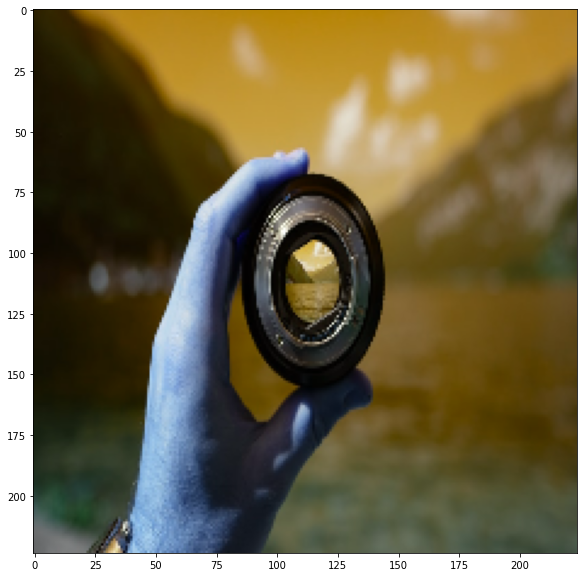

In [67]:
# read image tst.png using tensorflow
image = tf.io.read_file('tst.png')
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, 0)
image = tf.compat.v1.image.resize_bilinear(image, [224, 224])
image = tf.reverse(image,axis=[-1])
plt.figure(figsize=(10,10))
plt.imshow(image[0])

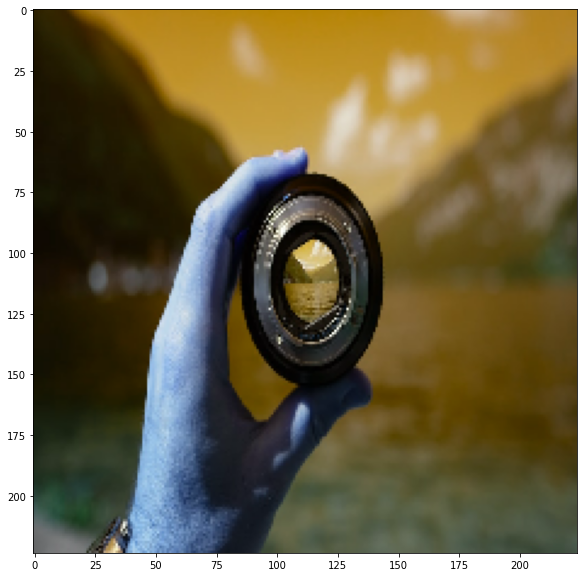

In [69]:
image = tf.io.read_file('tst.png')
image = tf.image.decode_png(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.expand_dims(image, 0)
image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image = tf.reverse(image,axis=[-1])
plt.figure(figsize=(10,10))
plt.imshow(image[0])